In [1]:
import pandas as pd 
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, roc_auc_score, mean_absolute_percentage_error
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import warnings
warnings.filterwarnings('ignore')

import gc

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.expand_frame_repr', False)

In [2]:
df = pd.read_csv('/Users/may/Desktop/Applied/Walmart Bootcamp/Capstone Project/Data/data.csv', index_col=0)

In [3]:
# Column types
df.astype('object').describe().transpose()

,count,unique,top,freq
uniq_id,10000,10000,eac7efa5dbd3d667f26eb3d3ab504464,1
product_name,10000,9964,Polyhedral Dice,3
manufacturer,9993,2651,LEGO,171
price,8565,2625,£9.99,189
number_available_in_stock,7500,89,2 new,1337
number_of_reviews,9982.0,194.0,1.0,4315.0
number_of_answered_questions,9235.0,19.0,1.0,6435.0
average_review_rating,9982,19,5.0 out of 5 stars,5140
category_and_sub_category,9310,255,"['Die-Cast & Toy Vehicles', 'Toy Vehicles & Ac...",880
customers_who_bought_this_item_also_bought,8938,8755,http://www.onlineretail.co/Scalextric | http:/...,60


In [4]:
df = df[['product_name', 'manufacturer', 'number_of_answered_questions', 'description', 'price_1', 'category_1', 'category_2', 'in_stock_num', 'in_stock_type']]

In [5]:
df.isnull().sum()

product_name                       0
manufacturer                       7
number_of_answered_questions     765
description                      651
price_1                         1453
category_1                       690
category_2                       690
in_stock_num                    2500
in_stock_type                   2500
dtype: int64

In [6]:
# Impute missing values
def fill_missing_value(data):
    data['manufacturer'].fillna(value = 'Unknown', inplace=True)
    data['number_of_answered_questions'].fillna(value = 0, inplace=True)
    data['description'].fillna(value = 'No description yet', inplace=True)
    data['category_1'].fillna(value = 'Other', inplace=True)
    data['category_2'].fillna(value = 'Other', inplace=True)
    data['in_stock_num'].fillna(value = 0, inplace=True)
    data['in_stock_type'].fillna(value = 'Unknown', inplace=True)
    return data

In [7]:
df = fill_missing_value(df)
df = df.dropna(subset=['price_1'])

In [8]:
df.isnull().sum()

product_name                    0
manufacturer                    0
number_of_answered_questions    0
description                     0
price_1                         0
category_1                      0
category_2                      0
in_stock_num                    0
in_stock_type                   0
dtype: int64

# Text preprocessing

In [9]:
from string import punctuation
import string
from pandas.core.groupby.generic import DataFrame

# Stem the Words
from nltk.stem.porter import PorterStemmer
porter = PorterStemmer()

# Create a list of punctuation replacements
punctuation_symbols = []
for symbol in punctuation:
    punctuation_symbols.append((symbol, ''))

nltk.download('stopwords')

# List of stop words
from nltk.corpus import stopwords
stop = stopwords.words('english')

[nltk_data] Downloading package stopwords to /Users/may/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
# Function to remove punctuations
def remove_punctuation(sentence: str) -> str:
    return sentence.translate(str.maketrans('', '', string.punctuation))

# Function to remove stop words
def remove_stop_words(x):
    x = ' '.join([i for i in x.lower().split(' ') if i not in stop])
    return x

# Function to lowercase the words
def to_lower(x):
    return x.lower()

In [11]:
df['description'] = df['description'].apply(porter.stem)
df['description'] = df['description'].apply(remove_punctuation)
df['description'] = df['description'].apply(remove_stop_words)
df['description'] = df['description'].apply(to_lower)

In [12]:
# Perform a TFIDF Transformation of the item description with the top 55000 features and has an n-gram range of 1-2
tv = TfidfVectorizer(max_features=55000, ngram_range=(1, 2), stop_words='english')
X_description = tv.fit_transform(df['description'])
print("Item Description Shape: " + str(X_description.shape))

Item Description Shape: (8547, 55000)


In [13]:
tfidf_weights = dict(zip(tv.get_feature_names(), tv.idf_))
tfidf_weights = pd.DataFrame(columns = ['tfidf_weights']).from_dict(dict(tfidf_weights), orient = 'index')
tfidf_weights.columns = ['tfidf_weights']

#Lowest tfidf scores -  Highest frequency words that get most importance:
tfidf_weights.sort_values(by=['tfidf_weights'], ascending=True).head(10)

,tfidf_weights
description,1.955722
product,2.081331
box,2.174540
product description,2.190955
contains,2.226212
box contains,2.332547
new,3.052207
children,3.113230
suitable,3.162843
set,3.164880


In [14]:
#Hightest tfidf scores - Rare words that get most importance:
tfidf_weights.sort_values(by=['tfidf_weights'], ascending=False).head(10)

,tfidf_weights
ﬁgure,9.360305
finishing spots,9.360305
turning activation,9.360305
fine grade,9.360305
fine nib,9.360305
turnator,9.360305
finger crayons,9.360305
finish exxod,9.360305
finish flag,9.360305
finish puzzle,9.360305


In [15]:
# Perform a TFIDF Transformation of the item product name with the top 700 features and has an n-gram range of 1-2
tv2 = TfidfVectorizer(max_features=700, ngram_range=(1, 2), stop_words='english')
X_product_name = tv2.fit_transform(df['product_name'])
print("Item product_name Shape: " + str(X_product_name.shape))

Item product_name Shape: (8547, 700)


In [16]:
X_dummies = csr_matrix(pd.get_dummies(df[['manufacturer', 'in_stock_type', 'category_1', 'category_2']], sparse=True).values)
X_dummies.shape

(8547, 2548)

In [17]:
X_num = csr_matrix(df[['number_of_answered_questions', 'in_stock_num']])
X_num.shape

(8547, 2)

In [18]:
# Combine everything together using Sparse matrix
sparse_merge = hstack((X_dummies, X_num, X_product_name, X_description))

print(sparse_merge.shape)

(8547, 58250)


In [19]:
target =df['price_1']

print(target.shape)

(8547,)


In [20]:
#Split into train anda test sets
from sklearn.model_selection import train_test_split
features_train, features_test, target_train, target_test = train_test_split(sparse_merge, target, test_size = .25, random_state = 42)

In [20]:
# from xgboost.sklearn import XGBRegressor
import xgboost as xgb

xgboost = xgb.XGBRegressor(
    # tree_method = "gpu_exact", 
    objective='reg:squarederror',
    n_estimators=500,
    learning_rate=0.1,
    subsample=0.5,
    colsample_bytree=1, 
    max_depth=7,
    gamma=0,
)
# log_xgboost = TransformedTargetRegressor(xgboost, func = np.log1p, inverse_func=np.expm1)
%time xgboost.fit(features_train, np.log1p(target_train))

CPU times: user 1min 58s, sys: 1.09 s, total: 2min
Wall time: 42.4 s


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=7, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
import tensorflow as tf
from tensorflow.keras.preprocessing import text
# import keras.backend.tensorflow_backend as K
# K.set_session
import shap
from shap import TreeExplainer
explainer = TreeExplainer(xgboost)


num_explanations = 20
shap_vals = explainer.shap_values(X_test[:num_explanations])
words = processor._tokenizer.word_index
word_lookup = list()
for i in words.keys():
  word_lookup.append(i)
word_lookup = [''] + word_lookup
shap.summary_plot(shap_vals, feature_names=word_lookup, class_names=tag_encoder.classes_)

# Without Text data

In [21]:
X = df[['manufacturer',
       'number_of_answered_questions',
         'category_1', 'category_2','in_stock_num', 'in_stock_type']]
y = df['price_1']

In [22]:
X =  pd.get_dummies(X)
y_trans = np.log(y+1)
X.shape

(8547, 2550)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

print("Train df shape:", X_train.shape)
print("Test df shape:", X_test.shape)

Train df shape: (6410, 2550)
Test df shape: (2137, 2550)


In [59]:
from sklearn.linear_model import LinearRegression
from sklearn.compose import TransformedTargetRegressor
linreg = LinearRegression()
log_linreg = TransformedTargetRegressor(linreg, func = np.log1p, inverse_func=np.expm1)
# log_linreg.fit(X_train,y_train)
linreg.fit(X_train, y_train)

LinearRegression()

Model Performance
R-squared: 0.7298091000662242
Root Mean Squared Error: 208165927465.22537
Mean Absolute Error: 39818443600.27771


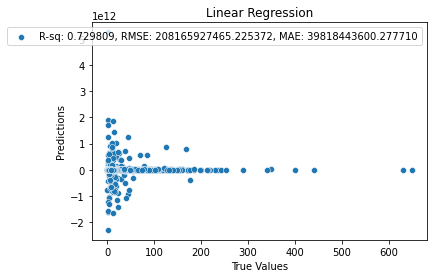

In [60]:
predictions = linreg.predict(X_test)
print('Model Performance')
r2=linreg.score(X_train, y_train)
print("R-squared:", r2)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print("Root Mean Squared Error:", rmse)
mae = mean_absolute_error(y_test, predictions)
print('Mean Absolute Error:',mae)    
sns.scatterplot(y_test, predictions,  label = "R-sq: %f, RMSE: %f, MAE: %f" %(r2, rmse, mae))
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title("Linear Regression");

In [ ]:
from sklearn.ensemble import RandomForestRegressor

Rforest = RandomForestRegressor(n_estimators=50, criterion='squared_error', max_depth=100, min_samples_split=2,
                                max_features='auto', min_impurity_decrease=0.0)
# log_Rforest = TransformedTargetRegressor(Rforest, func = np.log1p, inverse_func=np.expm1)
%time Rforest.fit(X_train, y_train)

CPU times: user 1min, sys: 194 ms, total: 1min
Wall time: 50.4 s


RandomForestRegressor(max_depth=100, n_estimators=50)

R-squared: 0.8155880361325664
Root Mean Squared Error: 33.61686068140614
Mean Absolute Error: 13.31004473262144


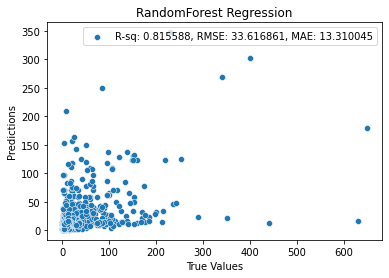

In [ ]:
predictions = Rforest.predict(X_test)

# print('Model Performance')
r2 = Rforest.score(X_train, y_train)
print("R-squared:", r2)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print("Root Mean Squared Error:", rmse)
mae = mean_absolute_error(y_test, predictions)
print('Mean Absolute Error:',mae)
    
sns.scatterplot(y_test, predictions,  label = "R-sq: %f, RMSE: %f, MAE: %f" %(r2, rmse, mae))
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title("RandomForest Regression");

In [ ]:
# from xgboost.sklearn import XGBRegressor
import xgboost as xgb

xgboost = xgb.XGBRegressor(
    tree_method = "gpu_hist", 
    objective='reg:squarederror',
    n_estimators=1000,
    learning_rate=0.1,
    subsample=0.5,
    colsample_bytree=1, 
    max_depth=7,
    gamma=0,
)
%time xgboost.fit(X_train, y_train)

CPU times: user 19.1 s, sys: 1.01 s, total: 20.1 s
Wall time: 17.7 s


XGBRegressor(max_depth=7, n_estimators=1000, objective='reg:squarederror',
             subsample=0.5, tree_method='gpu_hist')

R-squared: 0.8494842458880936
Root Mean Squared Error: 34.451630888929806
Mean Absolute Error: 14.379010029289843


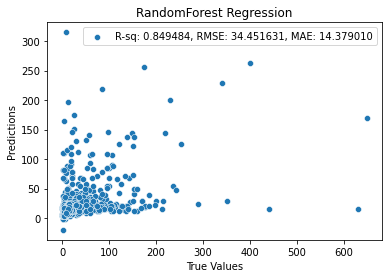

In [ ]:
predictions = xgboost.predict(X_test)

# print('Model Performance')
r2=xgboost.score(X_train, y_train)
print("R-squared:", r2)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print("Root Mean Squared Error:", rmse)
mae = mean_absolute_error(y_test, predictions)
print('Mean Absolute Error:',mae)
    
sns.scatterplot(y_test, predictions,  label = "R-sq: %f, RMSE: %f, MAE: %f" %(r2, rmse, mae))
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title("RandomForest Regression");

In [ ]:
# from xgboost.sklearn import XGBRegressor
import xgboost as xgb

xgboost = xgb.XGBRegressor(
    tree_method = "gpu_hist", 
    objective='reg:squarederror',
    n_estimators=1000,
    learning_rate=0.1,
    subsample=0.5,
    colsample_bytree=1, 
    max_depth=7,
    gamma=0,
)
log_xgboost = TransformedTargetRegressor(xgboost, func = np.log1p, inverse_func=np.expm1)
%time log_xgboost.fit(X_train, y_train)

CPU times: user 27.7 s, sys: 475 ms, total: 28.2 s
Wall time: 24.4 s


TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=XGBRegressor(max_depth=7,
                                                  n_estimators=1000,
                                                  objective='reg:squarederror',
                                                  subsample=0.5,
                                                  tree_method='gpu_hist'))

R-squared: 0.611533027554616
Root Mean Squared Error: 33.49809507845304
Mean Absolute Error: 12.42286393947115


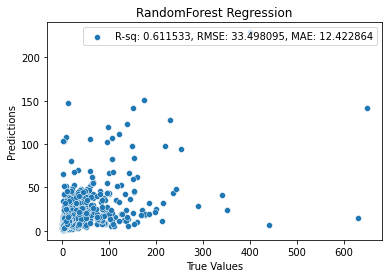

In [ ]:
predictions = log_xgboost.predict(X_test)

# print('Model Performance')
r2=log_xgboost.score(X_train, y_train)
print("R-squared:", r2)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print("Root Mean Squared Error:", rmse)
mae = mean_absolute_error(y_test, predictions)
print('Mean Absolute Error:',mae)
    
sns.scatterplot(y_test, predictions,  label = "R-sq: %f, RMSE: %f, MAE: %f" %(r2, rmse, mae))
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title("RandomForest Regression");

# With Text data

In [24]:
X_train, X_test, y_train, y_test = train_test_split(sparse_merge, target, test_size = .25, random_state = 42)

print("Train df shape:", X_train.shape)
print("Test df shape:", X_test.shape)

Train df shape: (6410, 58250)
Test df shape: (2137, 58250)


In [25]:
# from xgboost.sklearn import XGBRegressor
import xgboost as xgb

xgboost = xgb.XGBRegressor(
    # tree_method = "gpu_hist", 
    objective='reg:squarederror',
    n_estimators=500,
    learning_rate=0.1,
    subsample=0.5,
    colsample_bytree=1, 
    max_depth=7,
    gamma=0,
)
# log_xgboost = TransformedTargetRegressor(xgboost, func = np.log1p, inverse_func=np.expm1)
%time xgboost.fit(X_train, np.log1p(y_train))

CPU times: user 1min 46s, sys: 1.36 s, total: 1min 47s
Wall time: 46.5 s


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=7, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

R-squared: 0.8799532616707387
Root Mean Squared Error: 31.382558425039534
Mean Absolute Error: 11.478814936107042


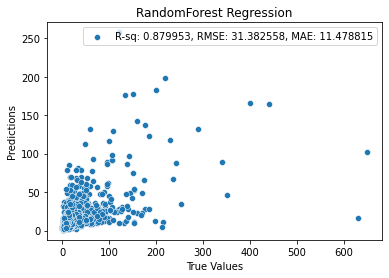

In [26]:
preds = np.expm1(xgboost.predict(X_test))

# print('Model Performance')
r2=xgboost.score(X_train, np.log1p(y_train))
print("R-squared:", r2)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("Root Mean Squared Error:", rmse)
mae = mean_absolute_error(y_test, preds)
print('Mean Absolute Error:',mae)
    
sns.scatterplot(y_test, preds,  label = "R-sq: %f, RMSE: %f, MAE: %f" %(r2, rmse, mae))
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title("RandomForest Regression");

# Feature Importance

In [12]:
X_cat = pd.get_dummies(df[['manufacturer', 'in_stock_type', 'category_1', 'category_2']], sparse=True)
X_cat.shape

(8547, 2548)

In [13]:
X_dummies = X_cat.values
X_dummies.shape

(8547, 2548)

In [14]:
X_num = df[['number_of_answered_questions', 'in_stock_num']]
X_num.shape

(8547, 2)

In [15]:
# Perform a TFIDF Transformation of the item description with the top 55000 features and has an n-gram range of 1-2
tv = TfidfVectorizer(max_features=55000, ngram_range=(1, 2), stop_words='english')
X_description = tv.fit_transform(df['description'])
print("Item Description Shape: " + str(X_description.shape))

Item Description Shape: (8547, 55000)


In [16]:
# Perform a TFIDF Transformation of the item product name with the top 700 features and has an n-gram range of 1-2
tv2 = TfidfVectorizer(max_features=700, ngram_range=(1, 2), stop_words='english')
X_product_name = tv2.fit_transform(df['product_name'])
print("Item product_name Shape: " + str(X_product_name.shape))

Item product_name Shape: (8547, 700)


In [17]:
# Combine everything together using Sparse matrix
X = hstack((X_dummies, X_num, X_product_name, X_description))
print(X.shape)

(8547, 58250)


In [20]:
y = df['price_1']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 42)

print("Train df shape:", X_train.shape)
print("Test df shape:", X_test.shape)

Train df shape: (6410, 58250)
Test df shape: (2137, 58250)


In [23]:
# from xgboost.sklearn import XGBRegressor
import xgboost as xgb

xgboost = xgb.XGBRegressor(
    # tree_method = "gpu_hist", 
    objective='reg:squarederror',
    n_estimators=500,
    learning_rate=0.1,
    subsample=0.5,
    colsample_bytree=1, 
    max_depth=7,
    gamma=0,
)
# log_xgboost = TransformedTargetRegressor(xgboost, func = np.log1p, inverse_func=np.expm1)
%time xgboost.fit(X_train, np.log1p(y_train))

CPU times: user 1min 57s, sys: 866 ms, total: 1min 58s
Wall time: 37.9 s


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=7, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [24]:
feature1 = list(X_cat.columns)
feature2 = ['number_of_answered_questions', 'in_stock_num']
feature3 = tv2.get_feature_names()
feature4 = tv.get_feature_names()
feature = feature1+feature2+feature3+feature4

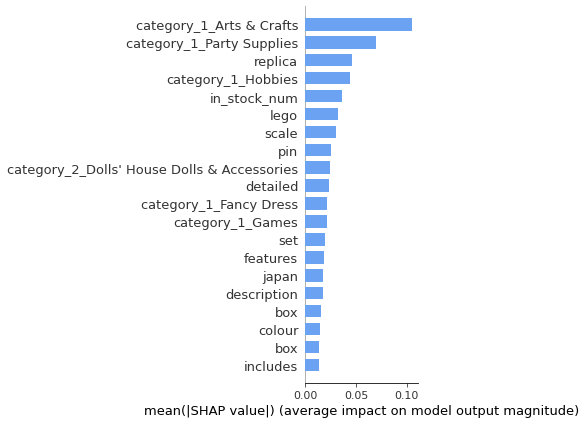

In [29]:
import shap
from shap import TreeExplainer
from matplotlib.colors import ListedColormap

explainer = TreeExplainer(xgboost)
num_explanations = 20
shap_vals = explainer.shap_values(X_test[:num_explanations], check_additivity=False)
cmap = ListedColormap(["#6ba3f2", "#6ba3f2"])

fig, ax = plt.subplots(1,1)
p = shap.summary_plot(shap_vals,  plot_size=(6,6), color = '#6ba3f2', plot_type="bar", feature_names=feature)
fig.show()

# ANN

In [32]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping

In [33]:
model = Sequential()
model.add(Dense(units = 512 ,kernel_initializer = 'normal', activation = 'relu', input_dim = 108229))
model.add(Dense(256, kernel_initializer='normal', activation = 'relu'))
model.add(Dense(256, kernel_initializer='normal', activation = 'relu'))
model.add(Dense(128, kernel_initializer='normal', activation = 'relu'))
model.add(Dense(1, kernel_initializer='normal',activation='linear'))
# Compiling my model:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               55413760  
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dense_3 (Dense)             (None, 128)               32896     
                                                                 
 dense_4 (Dense)             (None, 1)                 129       
                                                                 
Total params: 55,643,905
Trainable params: 55,643,905
Non-trainable params: 0
_________________________________________________________________


In [35]:
features_train = X_train
target_train = np.log1p(y_train)
features_test = X_test
target_test = np.log1p(y_test)

In [36]:
# model = TransformedTargetRegressor(model, func = np.log1p, inverse_func=np.expm1)
es =  EarlyStopping(monitor='val_loss', mode='min', min_delta=0, verbose=1, patience=20)
%time history = model.fit(features_train, target_train, validation_data=(features_test, target_test), epochs=40, verbose=2, callbacks=[es])

Epoch 1/40
201/201 - 7s - loss: 0.7758 - mae: 0.6360 - val_loss: 0.4539 - val_mae: 0.5020 - 7s/epoch - 35ms/step
Epoch 2/40
201/201 - 2s - loss: 0.2471 - mae: 0.3753 - val_loss: 0.4612 - val_mae: 0.5206 - 2s/epoch - 9ms/step
Epoch 3/40
201/201 - 2s - loss: 0.0955 - mae: 0.2248 - val_loss: 0.4750 - val_mae: 0.5064 - 2s/epoch - 9ms/step
Epoch 4/40
201/201 - 2s - loss: 0.0623 - mae: 0.1812 - val_loss: 0.3963 - val_mae: 0.4696 - 2s/epoch - 9ms/step
Epoch 5/40
201/201 - 2s - loss: 0.0430 - mae: 0.1480 - val_loss: 0.4079 - val_mae: 0.4726 - 2s/epoch - 9ms/step
Epoch 6/40
201/201 - 2s - loss: 0.0384 - mae: 0.1420 - val_loss: 0.4221 - val_mae: 0.4769 - 2s/epoch - 9ms/step
Epoch 7/40
201/201 - 2s - loss: 0.0430 - mae: 0.1527 - val_loss: 0.4008 - val_mae: 0.4722 - 2s/epoch - 9ms/step
Epoch 8/40
201/201 - 2s - loss: 0.0446 - mae: 0.1546 - val_loss: 0.4035 - val_mae: 0.4693 - 2s/epoch - 9ms/step
Epoch 9/40
201/201 - 2s - loss: 0.0446 - mae: 0.1547 - val_loss: 0.4330 - val_mae: 0.4832 - 2s/epoch - 

In [37]:
model.save('ann_price_colab.pkl')

In [38]:
target_pred = np.expm1(model.predict(features_test))
# print('Model Performance')
rmse = np.sqrt(mean_squared_error(target_test, target_pred))
print("Root Mean Squared Error:", rmse)
mae = mean_absolute_error(target_test, target_pred)
print('Mean Absolute Error:',mae)

67/67 [==============================] - 1s 20ms/step
Root Mean Squared Error: 19.24728833106144
Mean Absolute Error: 12.102895441891153


In [64]:
target_pred.transpose()[0]

array([10.947065, 28.882174, 11.111532, ..., 16.157057, 31.211542,
        8.566874], dtype=float32)

In [67]:
y_test.to_numpy()

array([11.5 , 22.11,  2.03, ..., 12.99, 74.65,  7.95])

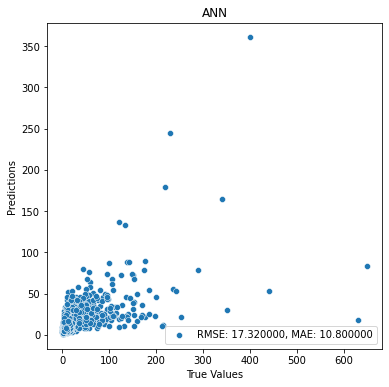

In [73]:
plt.figure(figsize=(6,6))
sns.scatterplot(y_test.to_numpy(), target_pred.transpose()[0],  label = "RMSE: %f, MAE: %f" %(17.32, 10.80))
plt.xlabel("True Values")
plt.ylabel("Predictions")

plt.title("ANN");

In [41]:
rmse = np.sqrt(mean_squared_error(target_test, target_pred))
print("Root Mean Squared Error:", rmse)
mae = mean_absolute_error(target_test, target_pred)
print('Mean Absolute Error:',mae)

Root Mean Squared Error: 19.24728833106144
Mean Absolute Error: 12.102895441891153


ValueError: ignored

Train: 0.082, Test: 0.462


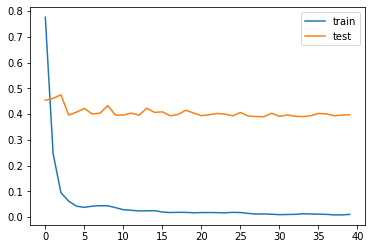

In [40]:
# evaluate the model
_, train_acc = model.evaluate(features_train, target_train, verbose=0)
_, test_acc = model.evaluate(features_test, target_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
from keras import backend as K
def r2_score(y_test, y_pred):
    SS_res =  K.sum(K.square(y_test-y_pred )) 
    SS_tot = K.sum(K.square( y_test - K.mean(y_test) ) ) 
    return ( 1 - SS_res/(SS_tot) )

In [ ]:
# current result
print(K.get_value(r2_score(K.constant(target_test), target_pred)))

-662466.25


#### With log transformation

In [ ]:
model = Sequential()
model.add(Dense(units = 512 ,kernel_initializer = 'normal', activation = 'relu', input_dim = 108229))
model.add(Dense(256, kernel_initializer='normal', activation = 'relu'))
model.add(Dense(256, kernel_initializer='normal', activation = 'relu'))
model.add(Dense(128, kernel_initializer='normal', activation = 'relu'))
model.add(Dense(1, kernel_initializer='normal',activation='linear'))
# Compiling my model:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])

In [ ]:
# model = TransformedTargetRegressor(model, func = np.log1p, inverse_func=np.expm1)
es =  EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)
%time history = model.fit(features_train.toarray(), np.log1p(target_train), validation_data=(features_test.toarray(), np.log1p(target_test)), epochs=20, verbose=2, callbacks=[es])

In [ ]:
target_pred = np.expm1(model.predict(features_test.toarray()))

67/67 [==============================] - 2s 31ms/step


In [ ]:
# print('Model Performance')
rmse = np.sqrt(mean_squared_error(target_test, target_pred))
print("Root Mean Squared Error:", rmse)
mae = mean_absolute_error(target_test, target_pred)
print('Mean Absolute Error:',mae)

Root Mean Squared Error: 34.60429151556747
Mean Absolute Error: 11.950360794118703


# Pipeline

In [30]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

In [31]:
from sklearn.preprocessing import FunctionTransformer

def text_transform(df):
    df['description'] = df['description'].apply(porter.stem)
    df['description'] = df['description'].apply(remove_punctuation)
    df['description'] = df['description'].apply(remove_stop_words)
    df['description'] = df['description'].apply(to_lower)
    return df

In [32]:
TextProcessor_1 = Pipeline(steps=[
    ('clean', FunctionTransformer(text_transform)),
    ("squeez", FunctionTransformer(lambda x: x.squeeze())),
    ("tfidf", TfidfVectorizer(max_features=55000, ngram_range=(1, 2), stop_words='english')),
    ("toarray", FunctionTransformer(lambda x: x.toarray())),
])

TextProcessor_2 = Pipeline(steps=[
    ("squeez", FunctionTransformer(lambda x: x.squeeze())),
    ("tfidf", TfidfVectorizer(max_features=55000, ngram_range=(1, 2), stop_words='english')),
    ("toarray", FunctionTransformer(lambda x: x.toarray())),
])

num_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])
cat_transformer = Pipeline(steps=[
    ('one-hot', OneHotEncoder())
])
preprocessor = ColumnTransformer(transformers=[
    ('text_1', TextProcessor_1, ['description']),
    ('text_2', TextProcessor_2, ['product_name']),
    ('num', num_transformer, ['number_of_answered_questions', 'in_stock_num']),
    ('one-hot', cat_transformer, ['manufacturer', 'in_stock_type', 'category_1', 'category_2'])
])

In [33]:
X = df[['product_name', 'description', 'number_of_answered_questions', 'in_stock_num', 'manufacturer', 'in_stock_type', 'category_1', 'category_2']]

In [34]:
X = preprocessor.fit_transform(X)

In [35]:
X = csr_matrix(X)

In [36]:
y = df['price_1']

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

print("Train df shape:", X_train.shape)
print("Test df shape:", X_test.shape)

Train df shape: (6410, 108229)
Test df shape: (2137, 108229)


In [38]:
# from xgboost.sklearn import XGBRegressor
import xgboost as xgb

xgboost = xgb.XGBRegressor(
    # tree_method = "gpu_hist", 
    objective='reg:squarederror',
    n_estimators=1000,
    learning_rate=0.1,
    subsample=0.5,
    colsample_bytree=1, 
    max_depth=7,
    gamma=0,
)
log_xgboost = TransformedTargetRegressor(xgboost, func = np.log1p, inverse_func=np.expm1)
%time log_xgboost.fit(X_train, y_train)

CPU times: user 5min 3s, sys: 2.84 s, total: 5min 6s
Wall time: 1min 53s


TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=XGBRegressor(base_score=None, booster=None,
                                                  callbacks=None,
                                                  colsample_bylevel=None,
                                                  colsample_bynode=None,
                                                  colsample_bytree=1,
                                                  early_stopping_rounds=None,
                                                  enable_categorical=False,
                                                  eval_metric=None, gamma=0,
                                                  gpu_id=None, grow_policy=None,
                                                  importance_type=None,
                                                  interaction_constraints=None,
                                                  learning_rate=0.1,
                        

In [40]:
import dill as pickle
with open('preprocessor.pkl', 'wb') as file:
    pickle.dump(preprocessor, file)

In [ ]:
import dill as pickle
with open('log_xgboost.pkl', 'wb') as file:
    pickle.dump(log_xgboost, file)